In [529]:
import os
import cv2
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [530]:
image = cv2.imread('test.jpg', cv2.COLOR_BGR2RGB)

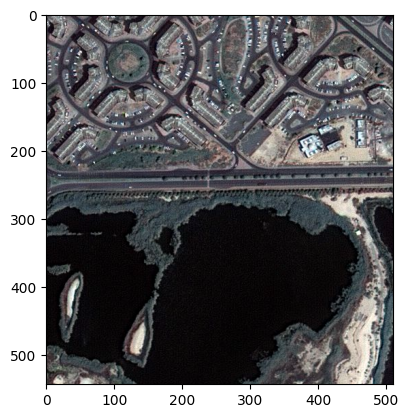

In [531]:
plt.imshow(image)

----

In [532]:
def load_dataset(root, img_size  = (128, 128)):
    img_array, mask_array = [], []
    for tiles in sorted(os.listdir(root)):
        img_cls_path = os.path.join(root, tiles, "images")
        mask_cls_path = os.path.join(root, tiles, "masks")
        if not os.path.isdir(img_cls_path): continue
        for files in os.listdir(img_cls_path):
            if not files.lower().endswith('jpg'): continue
            img_path = os.path.join(img_cls_path, files)
            mask_path = os.path.join(mask_cls_path, files.split('.')[0]+".png")
            if not os.path.exists(mask_path): continue

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size) / 255.0
            

            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = cv2.resize(mask, img_size)
            mask = np.expand_dims(mask,-1) / 255.0

            img_array.append(img)
            mask_array.append(mask)


    
    return np.array(img_array, dtype="float32"), np.array(mask_array, dtype="float32")

In [533]:
X, y = load_dataset("aerial_dataset", img_size=(128, 128))
print(X.shape)
print(y.shape)
print(f"Toplam örnek : {len(X)}")

(72, 128, 128, 3)
(72, 128, 128, 1)
Toplam örnek : 72


In [534]:
y.shape # pytorch için uygun

(72, 128, 128, 1)

In [535]:
X.shape # (H, W, C) format, pytorch -> (C, H, W) ister transform yaparken dönüştür.

(72, 128, 128, 3)

In [536]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

### U-Net Model

In [537]:
class Double_Conv2d(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding = 1),
            nn.BatchNorm2d(output_size),
            nn.ReLU(),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding = 1),
            nn.BatchNorm2d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv_block(x)

In [538]:
class U_Net(nn.Module):
    def __init__(self, input_size = 3):
        super().__init__()
        self.double_conv_1 = Double_Conv2d(input_size, 16)
        self.pool_1 = nn.MaxPool2d(2)

        self.double_conv_2 = Double_Conv2d(16, 32)
        self.pool_2 = nn.MaxPool2d(2)
        
        self.double_conv_3 = Double_Conv2d(32, 64)
        self.pool_3 = nn.MaxPool2d(2)

        self.double_conv_4 = Double_Conv2d(64, 128)
        self.pool_4 = nn.MaxPool2d(2)

        self.double_conv_5 = Double_Conv2d(128, 256)

        self.conv_transpose_4 = nn.ConvTranspose2d(256, 128, kernel_size=(2,2), stride = 2)
        self.double_conv_up_4 = Double_Conv2d(256, 128)

        self.conv_transpose_3 = nn.ConvTranspose2d(128, 64, kernel_size=(2,2), stride = 2)
        self.double_conv_up_3 = Double_Conv2d(128, 64)

        self.conv_transpose_2 = nn.ConvTranspose2d(64, 32, kernel_size=(2,2), stride = 2)
        self.double_conv_up_2 = Double_Conv2d(64, 32)

        self.conv_transpose_1 = nn.ConvTranspose2d(32, 16, kernel_size=(2,2), stride = 2)
        self.double_conv_up_1 = Double_Conv2d(32, 16)

        self.final_conv = nn.Conv2d(16, 1, kernel_size = 1)

    def forward(self, x):
        c1 = self.double_conv_1(x)
        p1 = self.pool_1(c1)
        c2 = self.double_conv_2(p1)
        p2 = self.pool_2(c2)
        c3 = self.double_conv_3(p2)
        p3 = self.pool_3(c3)
        c4 = self.double_conv_4(p3)
        p4 = self.pool_4(c4)

        c5 = self.double_conv_5(p4)

        ct_4 = self.conv_transpose_4(c5)
        ct_4 = torch.cat([ct_4, c4], dim = 1)
        ct_4 = self.double_conv_up_4(ct_4)

        ct_3 = self.conv_transpose_3(ct_4)
        ct_3 = torch.cat([ct_3, c3], dim = 1)
        ct_3 = self.double_conv_up_3(ct_3)

        ct_2 = self.conv_transpose_2(ct_3)
        ct_2 = torch.cat([ct_2, c2], dim = 1)
        ct_2 = self.double_conv_up_2(ct_2)

        ct_1 = self.conv_transpose_1(ct_2)
        ct_1 = torch.cat([ct_1, c1], dim = 1)
        ct_1 = self.double_conv_up_1(ct_1)

        output = self.final_conv(ct_1)

        return output

In [539]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform = None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

In [540]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [541]:
train_set = CustomDataset(images = X_train, masks = y_train, transform = transform)
test_set = CustomDataset(images = X_test, masks = y_test, transform = transform)

In [542]:
train_dataLoader = torch.utils.data.DataLoader(train_set, batch_size = 16, shuffle = True)
test_dataLoader = torch.utils.data.DataLoader(test_set, batch_size = 16, shuffle = False)

In [543]:
model = U_Net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

In [544]:
class EarlyStop:
    def __init__(self, patience = 5, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.counter += 1
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [545]:
early_stopping = EarlyStop()

In [546]:
def train_step(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer):
    
    train_loss = 0
    model.train()
    for image, mask in train_dataLoader:
        output = model(image)
        loss = loss_fn(output, mask)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_dataLoader)

    return train_loss

In [547]:
def test_step(model : torch.nn.Module,
              test_dataLoader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module):
    
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for image, mask in test_dataLoader:
            output = model(image)
            loss = loss_fn(output, mask)
            test_loss += loss.item()
            
            early_stopping(loss.item())
            if early_stopping.early_stop:
                print("Early Stopping Triggered!!!")
                break

        test_loss = test_loss / len(test_dataLoader)

    return test_loss

In [548]:
def train_test(model : torch.nn.Module,
               train_dataLoader : torch.utils.data.DataLoader,
               test_dataLoader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               epochs : int):

  results = {"train_loss": [],
             "test_loss": []}

  for epoch in range(epochs):
    train_loss = train_step(model = model,
                            train_dataLoader = train_dataLoader,
                            loss_fn = loss_fn,
                            optimizer = optimizer)

    test_loss = test_step(model = model,
                          test_dataLoader = test_dataLoader,
                          loss_fn = loss_fn)

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)

  return results

In [549]:
train_test(model = model,
            train_dataLoader = train_dataLoader,
            test_dataLoader = test_dataLoader,
            loss_fn = loss_fn,
            optimizer = optimizer,
            epochs = 15)

Epoch: 1 | train_loss: 0.7263 | test_loss: 169424400.0000
Epoch: 2 | train_loss: 0.6749 | test_loss: 273728.9062
Epoch: 3 | train_loss: 0.6670 | test_loss: 3060.5093
Epoch: 4 | train_loss: 0.6642 | test_loss: 1010.7398
Epoch: 5 | train_loss: 0.6597 | test_loss: 198.0978
Epoch: 6 | train_loss: 0.6677 | test_loss: 7.5694
Epoch: 7 | train_loss: 0.6639 | test_loss: 2.9975
Epoch: 8 | train_loss: 0.6669 | test_loss: 1.2622
Epoch: 9 | train_loss: 0.6612 | test_loss: 1.2857
Epoch: 10 | train_loss: 0.6630 | test_loss: 0.7559
Epoch: 11 | train_loss: 0.6590 | test_loss: 0.6905
Epoch: 12 | train_loss: 0.6580 | test_loss: 0.6685
Epoch: 13 | train_loss: 0.6577 | test_loss: 0.6682
Epoch: 14 | train_loss: 0.6564 | test_loss: 0.6611
Epoch: 15 | train_loss: 0.6586 | test_loss: 0.6618


{'train_loss': [0.7263021022081375,
  0.6749473214149475,
  0.6670477241277695,
  0.6641739159822464,
  0.659686878323555,
  0.6677434593439102,
  0.6639200001955032,
  0.6668771505355835,
  0.6611514091491699,
  0.6629756093025208,
  0.6589769721031189,
  0.6579570919275284,
  0.6576578915119171,
  0.656384140253067,
  0.6585854291915894],
 'test_loss': [169424400.0,
  273728.90625,
  3060.50927734375,
  1010.7398071289062,
  198.0978240966797,
  7.569369316101074,
  2.99753999710083,
  1.2622489929199219,
  1.2856730222702026,
  0.7559289336204529,
  0.690494179725647,
  0.668496310710907,
  0.6682482361793518,
  0.6611019968986511,
  0.6617900729179382]}

(128, 128, 3)
(128, 128, 1)
torch.Size([1, 1, 128, 128])


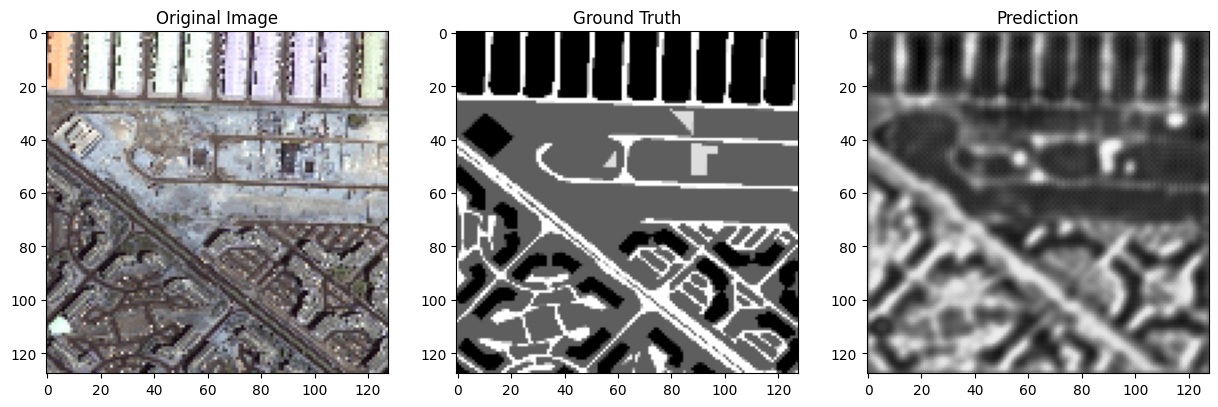

In [553]:
def show_prediction(model, idx):
    
    model.eval()
    with torch.inference_mode():
        image = X_test[idx]
        mask = y_test[idx]
        print(image.shape)
        print(mask.shape)
        output = model(torch.from_numpy(image.transpose(2,0,1)).unsqueeze(0))
        print(output.shape)
    
    fig, axes = plt.subplots(1, 3, figsize = (15,15))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[1].imshow(mask, cmap = "gray")
    axes[1].set_title("Ground Truth")
    axes[2].imshow(output.squeeze().numpy(), cmap = "gray")
    axes[2].set_title("Prediction")
show_prediction(model, 6)